# Simple user autoencoder

* Each user is one data example
* The representation of one user which consists of his ratings for 1000 movies is compressed to a hidden layer of 128 neurons
* When reconstructing the user from this embedding layer, the gaps are filled in (the ratings for movies which the user has not seen yet

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import tensorflow as tf

## Loading and preprocessig data

### Load train data

In [5]:
data = pd.read_csv("data/data_train.csv")
data = np.asarray(data)

### Split in train and test set

In [7]:
split = 10 # 10% test data
inds = np.random.permutation(len(data))
test_inds = inds[:len(data)//split]
train_inds = inds[len(data)//split:]

### Convert to two sparse matrices

In [8]:
train_matrix = np.zeros((10000,1000))
test_matrix = np.zeros((10000,1000))

for entry in data[train_inds]:
    field = entry[0].split("_")
    row = int(field[0][1:])
    col = int(field[1][1:])
    train_matrix[row-1, col-1] = entry[1]

for entry in data[test_inds]:
    field = entry[0].split("_")
    row = int(field[0][1:])
    col = int(field[1][1:])
    test_matrix[row-1, col-1] = entry[1]

### Normalize ratings to values between 0 and 1

In [9]:
train_matrix/=5
test_matrix/=5

## Define tensorflow graph

In [ ]:
def encode(x, keep_prob=1.0, n_hidden=512, n_embed=128, act_hidden=tf.nn.relu, act_out=tf.nn.relu):
    with tf.name_scope("encoder"):
        hidden = tf.layers.dense(x, n_hidden, activation=act_hidden)
        hidden = tf.nn.dropout(hidden, keep_prob=keep_prob)
        Z_mu = tf.layers.dense(hidden, n_embed, activation=act_out)
        return Z_mu

def decode(z, keep_prob=1.0, n_hidden=512, act_hidden=tf.nn.relu, act_out=None, nr_movies = 1000):
    with tf.name_scope("decoder"):
        hidden = tf.layers.dense(z, n_hidden, activation=act_hidden)
        hidden = tf.nn.dropout(hidden, keep_prob=keep_prob)
        outputs = tf.layers.dense(hidden, nr_movies, activation=act_out)
    return outputs

def masked_loss(mask, y):
    """
    RMSE loss - 
    masks entries that are zero in input (mask) 
    and computes loss only between the entries of reconstructed input (y) which is nonzero in mask
    """
    num_train_labels=tf.cast(tf.count_nonzero(mask),dtype=tf.float32) # number of non zero values in the training set
    bool_mask=tf.cast(mask,dtype=tf.bool) # boolean mask
    masked_y = tf.where(bool_mask, y, tf.zeros_like(y)) # set the output values to zero if corresponding input values are zero
    return tf.sqrt(tf.div(tf.reduce_sum(tf.square(tf.subtract(masked_y*5,mask*5))),num_train_labels))

In [21]:
learning_rate = 0.0001
n_hidden = 512
n_embed = 128
act_hidden_e = tf.nn.relu
act_out_e = tf.nn.relu
act_hidden_d = tf.nn.relu
act_out_d = None
nr_users = 10000
nr_movies = 1000
dropout_rate = 1 # no dropout
lamba = 0.001 # regularization hyperparameter

# Input placeholders
x_mask = tf.placeholder(tf.float32, (None, nr_movies), name="maskInput")
x = tf.placeholder(tf.float32, (None, nr_movies), name = "input")
drop_rate = tf.placeholder(tf.float32, name="dropoutPlaceholder")

# forward pass
Z = encode(x, n_hidden=n_hidden, n_embed=n_embed, act_hidden=act_hidden_e, act_out=act_out_e, keep_prob=drop_rate)
outputs = decode(Z, n_hidden=n_hidden, act_hidden=act_hidden_d, act_out=act_out_d, keep_prob=drop_rate)

# Loss
loss_op = masked_loss(x_mask, outputs)
l2_loss = tf.add_n([tf.nn.l2_loss(v) for v in tf.trainable_variables()])
loss_op_reg = loss_op + l2_loss * lamba

# Optimizer
train_op = tf.train.RMSPropOptimizer(learning_rate).minimize(loss_op_reg)

## Train model

In [28]:
batch_size = 8
epochs = 10

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    test_losses = []
    train_losses = []

    for epoch in range(epochs):
        train_losses_epoch=[]

        for user in range(nr_users//batch_size):
            sta = user*batch_size
            end = (user+1)*batch_size
            loss, _  = sess.run([loss_op, train_op], {x: train_matrix[sta:end], x_mask: train_matrix[sta:end], drop_rate: dropout_rate})
            train_losses_epoch.append(loss)

        
        test_loss = sess.run(loss_op, {x: train_matrix, x_mask: test_matrix, drop_rate:1.0})
        print("train", np.mean(train_losses_epoch), "test", test_loss)

        test_losses.append(test_loss)
        train_losses.append(np.mean(train_losses_epoch))


train 1.5098382 test 1.0461851
train 1.0223578 test 1.022763
train 0.9996674 test 1.0143312
train 0.99142575 test 1.0164019
train 0.9875083 test 1.0043389
train 0.9834572 test 1.0057999
train 0.98165506 test 1.0061885
train 0.97839797 test 0.998956
train 0.9771793 test 1.002149
train 0.9753387 test 0.99609214


### Plot test loss

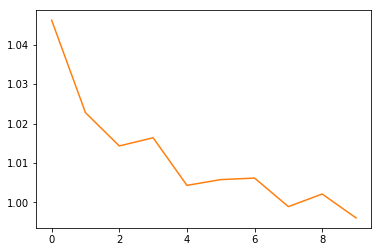

In [29]:
# plt.plot(train_losses)
plt.plot(test_losses)
plt.show()